## Get Datasets

In [1]:
!unzip 'train.zip'
!unzip 'test.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/NORMAL/NORMAL2-IM-0799-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0803-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0804-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0806-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0807-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0808-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0809-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0810-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0811-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0812-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0814-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0815-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0816-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0818-0001-0002.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0818-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0819-0001.jpeg  
  inflating: train/NORMAL/NORMAL2-IM-0820-0001.jpeg  
  inflating: train/NORMAL/

## 1. Import Libraries & Load images

In [1]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,  Activation, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from keras import layers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.preprocessing import image
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pandas as pd
import math
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
training_path = "train"
test_path = "test"

#### 1.1. Normalizing Data

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2,
                                      fill_mode='nearest')  #Divide pixels by 255(where pixel value range from 0-255) and scale them between 0-1
test_datagen = ImageDataGenerator(rescale=1./255)

#### 1.2. Generating Images

In [4]:
train_generator = train_datagen.flow_from_directory(training_path, target_size=(150,150), class_mode='binary', classes=['NORMAL', 'PNEUMONIA'])
test_generator = test_datagen.flow_from_directory(test_path, target_size=(150,150), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
train_class = train_generator.classes
test_class = test_generator.classes

## 2. Understanding and Manipulating the Data

#### 2.1. EDA

#### 2.1.1. Distribution of Training, Testing and Validation Dataset

In [40]:
from collections import Counter

train_counter = Counter(train_class)
val_counter = Counter(val_class)
test_counter = Counter(test_class)
print("Training: {}".format(train_counter))
print("Testing: {}".format(test_counter))

Training: Counter({1: 3875, 0: 1341})
Testing: Counter({1: 390, 0: 234})


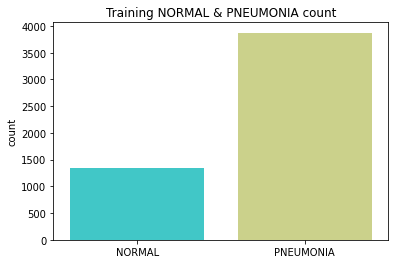

In [7]:
sns.countplot(x=train_class, palette="rainbow")
plt.title("Training NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

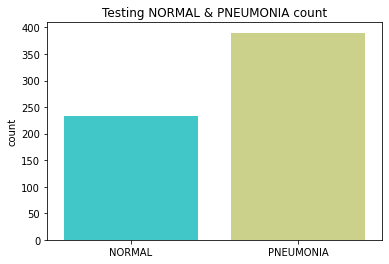

In [8]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Testing NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

#### 2.1.2. Viewing Sample Images

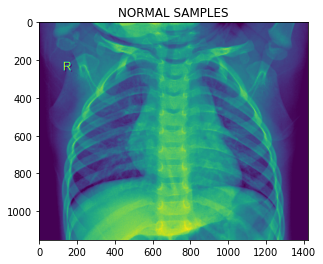

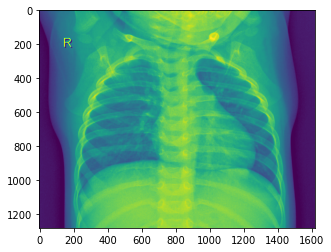

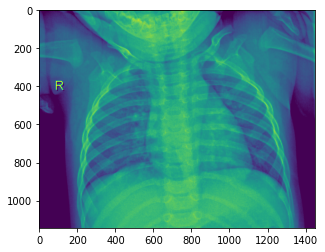

In [10]:
sample_li = [training_path + '/NORMAL/IM-0117-0001.jpeg', training_path + '/NORMAL/IM-0122-0001.jpeg', training_path + '/NORMAL/IM-0131-0001.jpeg']
plt.title("NORMAL SAMPLES")
for i in sample_li:
     img = mpimg.imread(i)
     imgplot = plt.imshow(img)
     plt.show()

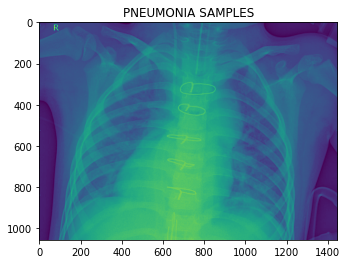

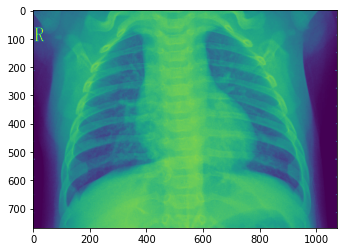

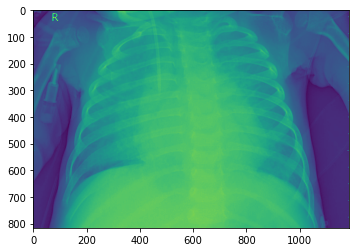

In [11]:
sample_li = [training_path + '/PNEUMONIA/person2_bacteria_3.jpeg', training_path + '/PNEUMONIA/person1000_virus_1681.jpeg', training_path + '/PNEUMONIA/person1004_bacteria_2935.jpeg']
plt.title("PNEUMONIA SAMPLES")
for i in sample_li:
     img = mpimg.imread(i)
     imgplot = plt.imshow(img)
     plt.show()

#### 2.2. Generating Weights for handling Imbalanced Data

In [12]:
df = pd.DataFrame({'data':train_generator.classes})
no_pne = int(df[df.data == train_generator.class_indices['NORMAL']].count())
yes_pne = int(df[df.data == train_generator.class_indices['PNEUMONIA']].count())

imb_rat = round(yes_pne / no_pne, 2)

no_weight = imb_rat
yes_weight = 1.0

cweights = {
    train_generator.class_indices['NORMAL']:no_weight,
    train_generator.class_indices['PNEUMONIA']:yes_weight
}

text = "Normal:{:.0f}\nPneumonia:{:.0f}\nImbalance Ratio: {:.2f}\n".format(no_pne, yes_pne, imb_rat)
print(text)
text = "Using class_weights as:\nNormal:{:.2f}\nPneumonia:{:.2f}\n".format(no_weight, yes_weight)
print(text)

Normal:1341
Pneumonia:3875
Imbalance Ratio: 2.89

Using class_weights as:
Normal:2.89
Pneumonia:1.00



#### 2.3. Assign input shape based on color channels

In [13]:
img_width, img_height = 150, 150

In [14]:
if k.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

## 3. Model Building

#### 3.1. Basic Convolutional Neural Network (CNN)

In [15]:
model = Sequential()
#Feature Extraction
#Block 1
model.add(Conv2D(32,(3,3),input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Classification
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have normal and pneumonia classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       2

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=25, batch_size=64, class_weight=cweights, validation_data=test_generator, verbose=1)

Epoch 1/25
163/163 [==============================] - 64s 367ms/step - loss: 0.5033 - accuracy: 0.8382 - val_loss: 7.1750 - val_accuracy: 0.6250
Epoch 2/25
163/163 [==============================] - 54s 334ms/step - loss: 0.3646 - accuracy: 0.8928 - val_loss: 10.2875 - val_accuracy: 0.6250
Epoch 3/25
163/163 [==============================] - 55s 334ms/step - loss: 0.2808 - accuracy: 0.9224 - val_loss: 3.0632 - val_accuracy: 0.6571
Epoch 4/25
163/163 [==============================] - 54s 333ms/step - loss: 0.2725 - accuracy: 0.9248 - val_loss: 0.5420 - val_accuracy: 0.8397
Epoch 5/25
163/163 [==============================] - 54s 334ms/step - loss: 0.2527 - accuracy: 0.9321 - val_loss: 1.8355 - val_accuracy: 0.5048
Epoch 6/25
163/163 [==============================] - 54s 333ms/step - loss: 0.2652 - accuracy: 0.9331 - val_loss: 0.8857 - val_accuracy: 0.7644
Epoch 7/25
163/163 [==============================] - 54s 332ms/step - loss: 0.2342 - accuracy: 0.9434 - val_loss: 0.7272 - val_a

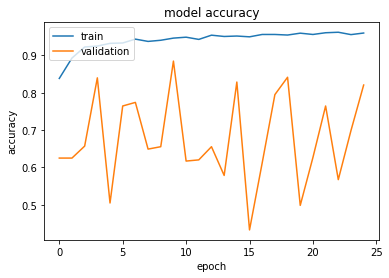

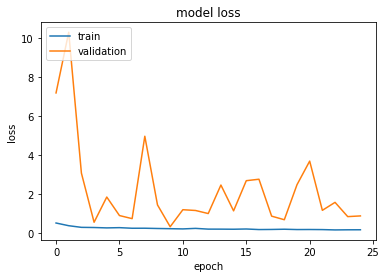

In [17]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 3.2. VGG16

In [18]:
num_of_classes = 2
batch_size = 32

base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
    
for layer in base_model.layers:
    if layer.name != 'block5_conv3':
        layer.trainable = False
    else:
        layer.trainable = True

x = base_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(x) #Pooling + Flatten
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
optSGD = optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model1.compile(loss='binary_crossentropy', optimizer=optSGD, metrics=['accuracy'])

In [20]:
hist_vgg = model1.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    class_weight=cweights,
                    epochs=70, verbose=1)

Epoch 1/70
163/163 [==============================] - 57s 329ms/step - loss: 0.9125 - accuracy: 0.6329 - val_loss: 0.5140 - val_accuracy: 0.8077
Epoch 2/70
163/163 [==============================] - 53s 326ms/step - loss: 0.5862 - accuracy: 0.8372 - val_loss: 0.4088 - val_accuracy: 0.8542
Epoch 3/70
163/163 [==============================] - 54s 328ms/step - loss: 0.4498 - accuracy: 0.8788 - val_loss: 0.3459 - val_accuracy: 0.8702
Epoch 4/70
163/163 [==============================] - 53s 326ms/step - loss: 0.3853 - accuracy: 0.8978 - val_loss: 0.3336 - val_accuracy: 0.8670
Epoch 5/70
163/163 [==============================] - 53s 326ms/step - loss: 0.3564 - accuracy: 0.9039 - val_loss: 0.3047 - val_accuracy: 0.8750
Epoch 6/70
163/163 [==============================] - 53s 326ms/step - loss: 0.3176 - accuracy: 0.9133 - val_loss: 0.2894 - val_accuracy: 0.8814
Epoch 7/70
163/163 [==============================] - 53s 327ms/step - loss: 0.3023 - accuracy: 0.9174 - val_loss: 0.2792 - val_ac

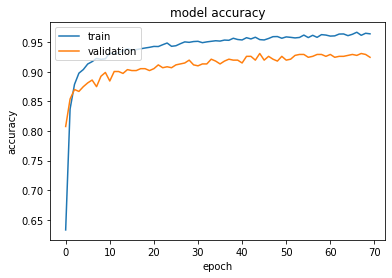

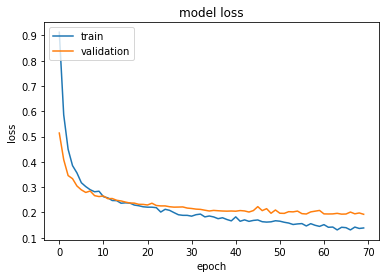

In [21]:
# "Accuracy"
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 3.3. RESNET50

In [22]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_model.layers:
    layer.trainable = False
    
x = Flatten()(resnet_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=resnet_model.input, outputs=x)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [23]:
model2.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy'])

hist_rest = model2.fit_generator(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 35s 187ms/step - loss: 0.9480 - accuracy: 0.6405 - val_loss: 0.4882 - val_accuracy: 0.7869
Epoch 2/70
163/163 [==============================] - 32s 182ms/step - loss: 0.6770 - accuracy: 0.7882 - val_loss: 0.4262 - val_accuracy: 0.7901
Epoch 3/70
163/163 [==============================] - 31s 182ms/step - loss: 0.5869 - accuracy: 0.8171 - val_loss: 0.3760 - val_accuracy: 0.8301
Epoch 4/70
163/163 [==============================] - 31s 182ms/step - loss: 0.5254 - accuracy: 0.8405 - val_loss: 0.3464 - val_accuracy: 0.8413
Epoch 5/70
163/163 [==============================] - 31s 180ms/step - loss: 0.4680 - accuracy: 0.8637 - val_loss: 0.3256 - val_accuracy: 0.8718
Epoch 6/70
163/163 [==============================] - 31s 181ms/step - loss: 0.4255 - accuracy: 0.8809 - val_loss: 0.3488 - val_accuracy: 0.8510
Epoch 7/70
163/163 [==============================] - 31s 180ms/step - loss: 0.4129 - accuracy: 0.8802 - val_loss: 0.3032 - val_ac

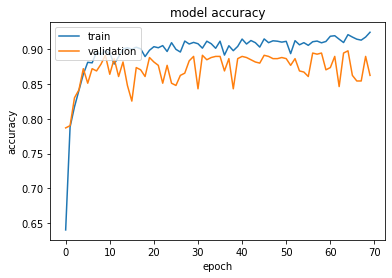

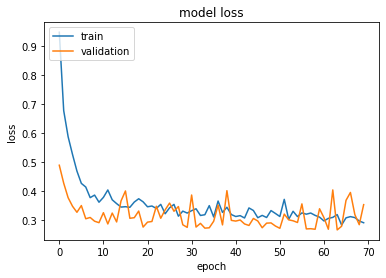

In [24]:
# "Accuracy"
plt.plot(hist_rest.history['accuracy'])
plt.plot(hist_rest.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_rest.history['loss'])
plt.plot(hist_rest.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 3.4. InceptionV3

In [25]:
base_model = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=output)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [26]:
opt = optimizers.Adam(learning_rate=0.0003)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

hist_incep = model3.fit_generator(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 37s 192ms/step - loss: 0.4160 - accuracy: 0.8660 - val_loss: 0.3064 - val_accuracy: 0.8782
Epoch 2/70
163/163 [==============================] - 31s 181ms/step - loss: 0.2974 - accuracy: 0.9149 - val_loss: 0.3448 - val_accuracy: 0.8429
Epoch 3/70
163/163 [==============================] - 31s 182ms/step - loss: 0.2938 - accuracy: 0.9245 - val_loss: 0.2916 - val_accuracy: 0.8782
Epoch 4/70
163/163 [==============================] - 31s 182ms/step - loss: 0.2741 - accuracy: 0.9285 - val_loss: 0.2754 - val_accuracy: 0.8910
Epoch 5/70
163/163 [==============================] - 31s 178ms/step - loss: 0.2676 - accuracy: 0.9339 - val_loss: 0.2501 - val_accuracy: 0.9087
Epoch 6/70
163/163 [==============================] - 32s 185ms/step - loss: 0.2603 - accuracy: 0.9339 - val_loss: 0.2505 - val_accuracy: 0.8958
Epoch 7/70
163/163 [==============================] - 31s 181ms/step - loss: 0.2619 - accuracy: 0.9337 - val_loss: 0.2474 - val_ac

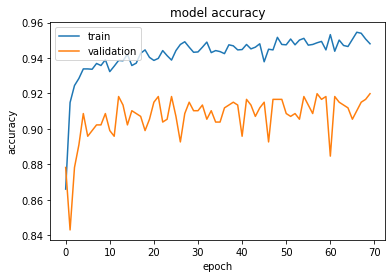

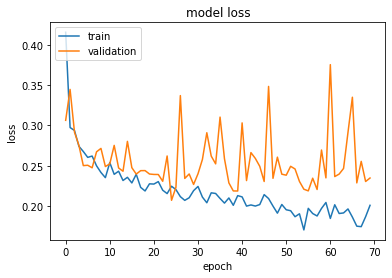

In [27]:
# "Accuracy"
plt.plot(hist_incep.history['accuracy'])
plt.plot(hist_incep.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_incep.history['loss'])
plt.plot(hist_incep.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Making Predictions

#### 4.1. Basic Convolutional Neural Network (CNN)

In [47]:
result_tabulation = pd.DataFrame(columns=["Model", "Loss", "Accuracy"])

pred_cnn = model.evaluate(test_generator)
CNN = pd.Series({"Model": "Basic CNN", "Loss": pred_cnn[0], "Accuracy": pred_cnn[1]})
result_tabulation = result_tabulation.append(CNN, ignore_index=True)
result_tabulation

20/20 [==============================] - 3s 147ms/step - loss: 0.8669 - accuracy: 0.8205


,Model,Loss,Accuracy
0,Basic CNN,0.866903,0.820513


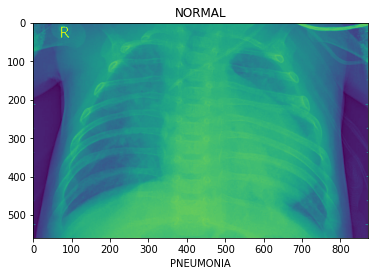

In [53]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

result = model.predict(img_pred)

if result[0][0] == 1:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"
plt.title(prediction)
plt.xlabel("PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

#### 4.2. VGG16

In [44]:
predict_vgg_test = model1.predict(test_generator)
pred_final_vgg = np.round(predict_vgg_test)

print(classification_report(test_class, pred_final_vgg))
print(confusion_matrix(test_class, pred_final_vgg))

              precision    recall  f1-score   support

           0       0.35      0.34      0.35       234
           1       0.61      0.62      0.62       390

    accuracy                           0.52       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.52      0.52       624

[[ 80 154]
 [147 243]]


In [48]:
pred_vgg = model1.evaluate(test_generator)
VGG =  pd.Series({"Model": "VGG16", "Loss": pred_vgg[0], "Accuracy": pred_vgg[1]})
result_tabulation = result_tabulation.append(VGG, ignore_index=True)
result_tabulation

20/20 [==============================] - 3s 147ms/step - loss: 0.1928 - accuracy: 0.9247


,Model,Loss,Accuracy
0,Basic CNN,0.866903,0.820513
1,VGG16,0.192845,0.924679


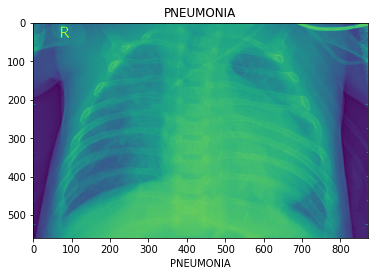

In [61]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model1.predict(img_pred)

if result[0][0] == 1:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"
plt.title(prediction)
plt.xlabel("PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

#### 4.3. RESNET50

In [49]:
pred_rest = model2.evaluate(test_generator)
RESTNET =  pd.Series({"Model": "RESTNET50", "Loss": pred_rest[0], "Accuracy": pred_rest[1]})
result_tabulation = result_tabulation.append(RESTNET, ignore_index=True)
result_tabulation

20/20 [==============================] - 3s 148ms/step - loss: 0.3520 - accuracy: 0.8622


,Model,Loss,Accuracy
0,Basic CNN,0.866903,0.820513
1,VGG16,0.192845,0.924679
2,RESTNET50,0.351962,0.862179


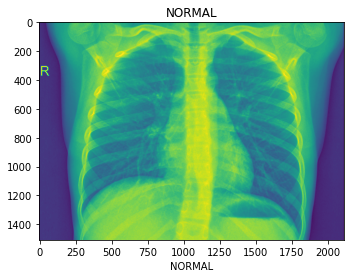

In [55]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model2.predict(img_pred)

if result[0][0] == 1:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"
plt.title(prediction)
plt.xlabel("NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

#### 4.4. InceptionV3

In [50]:
pred_incep = model3.evaluate(test_generator)
RESTNET =  pd.Series({"Model": "InceptionV3", "Loss": pred_incep[0], "Accuracy": pred_incep[1]})
result_tabulation = result_tabulation.append(RESTNET, ignore_index=True)
result_tabulation

20/20 [==============================] - 3s 149ms/step - loss: 0.2346 - accuracy: 0.9199


,Model,Loss,Accuracy
0,Basic CNN,0.866903,0.820513
1,VGG16,0.192845,0.924679
2,RESTNET50,0.351962,0.862179
3,InceptionV3,0.234637,0.919872


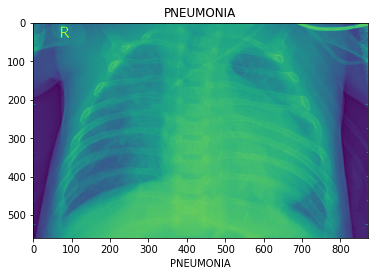

In [65]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"
plt.title(prediction)
plt.xlabel("PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

## 5. Conclusion

#### From the above results, we can conclude that VGG16 is much more stable and accurate model as compared to Basic Convolutional Neural Network (CNN), RestNet50, InceptionV3 models. Hence, VGG16 is the preferred model for the prediction of Pneumonia patients.